# Ensemble Learning through Batch Boosting


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *
from basic_estimator_model import *

## Parameter Configuration

In [2]:
np.random.seed(2020)

In [87]:
N_train = 1000
N_test = 10000
Max_Iter = 100
Epsilon = 1e-4
Learning_Rate = 0.1
d = 1
T = 2

In [30]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [31]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [32]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [33]:
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = s_test.generate_true_V(T)
V_0 = s_test.generate_true_V(0)

V_T_train = s_train.generate_true_V(T)
V_0_train = s_train.generate_true_V(0)

V_0_train = V_0_train.mean()
V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.0791500965406784

In [34]:
from aggregating.utils import flatten_X, normalized_error_VT
#dim(N_test,d*T)
Flattened_X_test = flatten_X(X_test)
# dim(N_train, d*T)
Flattened_X_train = flatten_X(X_train)

In [35]:
#Model with Flatten_X_1
m_1 = EstimatorModelBase(kernel)
m_1.fit(Flattened_X_train,y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=39.2) + WhiteKernel(noise_level=0.5))

In [36]:
fX_1 = m_1._predict_fX(Flattened_X_test)

In [37]:
fX_2 = m_1._predict_fX(Flattened_X_train)

In [38]:
test_reference_error = normalized_error_VT(fX_1 ,V_T, V_0)

In [39]:
train_reference_error = normalized_error_VT(fX_2 ,V_T_train, V_0_train)

In [40]:
train_reference_error

0.020611583279537608

In [41]:
test_reference_error

0.13899458016521793

## Gradient Boosting

In [80]:
def Gradient_Boosting(X_train, y_train, X_test, y_test, Max_Iter, min_error, early_stop, kernel, learning_rate, epsilon):
    error_going_up = 0
    train_prediction = np.zeros(N_train)
    test_prediction = np.zeros(N_test)
    previous_y_hat = np.zeros(N_train)
    previous_y_test_hat = np.zeros(N_test)
    models = []
    train_errors = []
    test_errors = []
    
    current_residual = np.full(len(y_train), np.mean(y_train, axis=0))
    y_hat_test = np.full(len(y_test), np.mean(y_train, axis=0))

    
    for i in range(Max_Iter):
        model = GaussianProcessRegressor(kernel)
    
        model.fit(X_train, y_train - current_residual)
        models.append(model)
        
        new_train_predictor = model.predict(X_train)
        new_test_predictor = model.predict(X_test)
        
        current_residual += learning_rate * new_train_predictor
        
        y_hat_train = current_residual 
        
        y_hat_test += learning_rate * new_test_predictor
        
        #Evaluating TrainSet error
        
        train_errors.append(normalized_error_VT(y_hat_train,y_train,V_0_train).item())
        
        ##Evaluating TestSet error
        
        test_errors.append(normalized_error_VT(y_hat_test,y_test,V_0).item())
    
        if (( min_error[0] - test_errors[-1] > epsilon) & (test_errors[-1] < min_error[0])):
            min_error = (test_errors[-1], i)
            error_going_up = 0
            print('For iteration number {}, the test error decreased , test error : {} '.format(i, min_error[0]))
        else:
            error_going_up += 1
            print('For iteration number {}, the test error increased , test error : {} '.format(i, min_error[0]))
        
            if  (i==(Max_Iter-1)):
                models = models[:min_error[1]+1]
                
                return models, train_errors, test_errors, min_error
        
            elif (error_going_up == early_stop ):
                models = models[: -(early_stop)]
                
                return models, train_errors, test_errors, min_error
                break #early stopping
            
    return models, train_errors, test_errors, min_error

In [81]:


models, train_error, test_error, min_error = Gradient_Boosting(np.copy(Flattened_X_train), np.copy(y_train), np.copy(Flattened_X_test), np.copy(y_test), Max_Iter, (float("inf"), float("inf")), 3, kernel, Learning_Rate, Epsilon)



For iteration number 0, the test error decreased , test error : 1.5074233825376284 
For iteration number 1, the test error decreased , test error : 1.3598941812097793 
For iteration number 2, the test error decreased , test error : 1.2274580481463453 
For iteration number 3, the test error decreased , test error : 1.1086603058389375 
For iteration number 4, the test error decreased , test error : 1.0022037859819286 
For iteration number 5, the test error decreased , test error : 0.9036708763641776 
For iteration number 6, the test error decreased , test error : 0.8155829655366185 
For iteration number 7, the test error decreased , test error : 0.7368263525928354 
For iteration number 8, the test error decreased , test error : 0.6660456622266852 
For iteration number 9, the test error decreased , test error : 0.6018825678571692 
For iteration number 10, the test error decreased , test error : 0.5439263577647558 
For iteration number 11, the test error decreased , test error : 0.49189277

/Users/Clement/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


For iteration number 25, the test error decreased , test error : 0.147651218663989 
For iteration number 26, the test error decreased , test error : 0.13880843670607063 
For iteration number 27, the test error decreased , test error : 0.13111733592244906 
For iteration number 28, the test error decreased , test error : 0.12460723932128182 
For iteration number 29, the test error decreased , test error : 0.11898790168442722 
For iteration number 30, the test error decreased , test error : 0.11415325678404085 
For iteration number 31, the test error decreased , test error : 0.1100655665883595 
For iteration number 32, the test error decreased , test error : 0.10650478719880024 
For iteration number 33, the test error decreased , test error : 0.10353475859158766 
For iteration number 34, the test error decreased , test error : 0.101012202253846 
For iteration number 35, the test error decreased , test error : 0.09888086704340006 
For iteration number 36, the test error decreased , test er

/Users/Clement/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


For iteration number 42, the test error decreased , test error : 0.09085936250799638 
For iteration number 43, the test error decreased , test error : 0.09029554065465141 
For iteration number 44, the test error decreased , test error : 0.08981477716944743 
For iteration number 45, the test error decreased , test error : 0.0894040510485186 
For iteration number 46, the test error decreased , test error : 0.08905244680104289 
For iteration number 47, the test error decreased , test error : 0.08875082076544726 
For iteration number 48, the test error decreased , test error : 0.08849151351648177 
For iteration number 49, the test error decreased , test error : 0.08826811503240288 
For iteration number 50, the test error decreased , test error : 0.08807524974669721 
For iteration number 51, the test error decreased , test error : 0.08790779051561455 
For iteration number 52, the test error decreased , test error : 0.08776160843743609 
For iteration number 53, the test error decreased , tes

In [85]:
learning_rates = np.linspace(0.1, 0.5 , num=10)

In [100]:
min_errors = dict((val, []) for val in range(len(learning_rates))) 
min_errors[0] = (4 , 6)
min_errors

In [102]:
models = dict((val, []) for val in range(len(learning_rates))) 
train_errors = dict((val, []) for val in range(len(learning_rates))) 
test_errors = dict((val, []) for val in range(len(learning_rates))) 
min_errors = dict((val, []) for val in range(len(learning_rates))) 

for i in range(len(learning_rates)) :
    models[i], train_errors[i], test_errors[i], min_errors[i] = Gradient_Boosting(np.copy(Flattened_X_train), np.copy(y_train), np.copy(Flattened_X_test), np.copy(y_test), Max_Iter, (float("inf"), float("inf")), 3, kernel, learning_rates[i], Epsilon)

For iteration number 0, the test error decreased , test error : 1.5074233825376284 
For iteration number 1, the test error decreased , test error : 1.3598941812097793 
For iteration number 2, the test error decreased , test error : 1.2274580481463453 
For iteration number 3, the test error decreased , test error : 1.1086603058389375 
For iteration number 4, the test error decreased , test error : 1.0022037859819286 
For iteration number 5, the test error decreased , test error : 0.9036708763641776 
For iteration number 6, the test error decreased , test error : 0.8155829655366185 
For iteration number 7, the test error decreased , test error : 0.7368263525928354 
For iteration number 8, the test error decreased , test error : 0.6660456622266852 
For iteration number 9, the test error decreased , test error : 0.6018825678571692 
For iteration number 10, the test error decreased , test error : 0.5439263577647558 
For iteration number 11, the test error decreased , test error : 0.49189277

/Users/Clement/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


For iteration number 25, the test error decreased , test error : 0.147651218663989 
For iteration number 26, the test error decreased , test error : 0.13880843670607063 
For iteration number 27, the test error decreased , test error : 0.13111733592244906 
For iteration number 28, the test error decreased , test error : 0.12460723932128182 
For iteration number 29, the test error decreased , test error : 0.11898790168442722 
For iteration number 30, the test error decreased , test error : 0.11415325678404085 
For iteration number 31, the test error decreased , test error : 0.1100655665883595 
For iteration number 32, the test error decreased , test error : 0.10650478719880024 
For iteration number 33, the test error decreased , test error : 0.10353475859158766 
For iteration number 34, the test error decreased , test error : 0.101012202253846 
For iteration number 35, the test error decreased , test error : 0.09888086704340006 
For iteration number 36, the test error decreased , test er

/Users/Clement/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


For iteration number 42, the test error decreased , test error : 0.09085936250799638 
For iteration number 43, the test error decreased , test error : 0.09029554065465141 
For iteration number 44, the test error decreased , test error : 0.08981477716944743 
For iteration number 45, the test error decreased , test error : 0.0894040510485186 
For iteration number 46, the test error decreased , test error : 0.08905244680104289 
For iteration number 47, the test error decreased , test error : 0.08875082076544726 
For iteration number 48, the test error decreased , test error : 0.08849151351648177 
For iteration number 49, the test error decreased , test error : 0.08826811503240288 
For iteration number 50, the test error decreased , test error : 0.08807524974669721 
For iteration number 51, the test error decreased , test error : 0.08790779051561455 
For iteration number 52, the test error decreased , test error : 0.08776160843743609 
For iteration number 53, the test error decreased , tes

/Users/Clement/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


For iteration number 20, the test error decreased , test error : 0.1215667671476355 
For iteration number 21, the test error decreased , test error : 0.11603283777494745 
For iteration number 22, the test error decreased , test error : 0.11166133900793064 
For iteration number 23, the test error decreased , test error : 0.108226834515382 
For iteration number 24, the test error decreased , test error : 0.10555513038052136 
For iteration number 25, the test error decreased , test error : 0.1034914988576821 
For iteration number 26, the test error decreased , test error : 0.10187524031961127 
For iteration number 27, the test error decreased , test error : 0.10060566569443494 
For iteration number 28, the test error decreased , test error : 0.09960513227349199 
For iteration number 29, the test error decreased , test error : 0.09881358657829428 
For iteration number 30, the test error decreased , test error : 0.09818466778063263 
For iteration number 31, the test error decreased , test e

For iteration number 27, the test error increased , test error : 0.08189059479870209 
For iteration number 28, the test error increased , test error : 0.08189059479870209 
For iteration number 29, the test error decreased , test error : 0.08177720691533119 
For iteration number 30, the test error increased , test error : 0.08177720691533119 
For iteration number 31, the test error increased , test error : 0.08177720691533119 
For iteration number 32, the test error increased , test error : 0.08177720691533119 
For iteration number 0, the test error decreased , test error : 1.2158338702912501 
For iteration number 1, the test error decreased , test error : 0.8897617306052947 
For iteration number 2, the test error decreased , test error : 0.6508186358288908 
For iteration number 3, the test error decreased , test error : 0.4779842378975541 
For iteration number 4, the test error decreased , test error : 0.35420533884435557 
For iteration number 5, the test error decreased , test error :

/Users/Clement/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


For iteration number 19, the test error decreased , test error : 0.09074339974320998 


/Users/Clement/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


For iteration number 20, the test error decreased , test error : 0.09062200991434384 
For iteration number 21, the test error increased , test error : 0.09062200991434384 
For iteration number 22, the test error decreased , test error : 0.09047687252992806 
For iteration number 23, the test error increased , test error : 0.09047687252992806 
For iteration number 24, the test error increased , test error : 0.09047687252992806 
For iteration number 25, the test error increased , test error : 0.09047687252992806 
For iteration number 0, the test error decreased , test error : 1.143056882621129 
For iteration number 1, the test error decreased , test error : 0.7894410481231806 
For iteration number 2, the test error decreased , test error : 0.5477262429981992 
For iteration number 3, the test error decreased , test error : 0.3829823472013884 
For iteration number 4, the test error decreased , test error : 0.2757253431652457 
For iteration number 5, the test error decreased , test error : 0

/Users/Clement/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


For iteration number 4, the test error decreased , test error : 0.21862634155448307 
For iteration number 5, the test error decreased , test error : 0.16672770080598084 
For iteration number 6, the test error decreased , test error : 0.1385622108363106 
For iteration number 7, the test error decreased , test error : 0.12438035640781729 
For iteration number 8, the test error decreased , test error : 0.11742480100144444 
For iteration number 9, the test error decreased , test error : 0.11402973199766545 
For iteration number 10, the test error decreased , test error : 0.11227825381588556 
For iteration number 11, the test error decreased , test error : 0.11133717262496953 
For iteration number 12, the test error decreased , test error : 0.11080856448049953 
For iteration number 13, the test error decreased , test error : 0.11049735805140089 
For iteration number 14, the test error decreased , test error : 0.11030973273733866 
For iteration number 15, the test error decreased , test erro

/Users/Clement/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


For iteration number 6, the test error decreased , test error : 0.09756561364447552 
For iteration number 7, the test error decreased , test error : 0.09598562313198575 
For iteration number 8, the test error decreased , test error : 0.09534537676827007 
For iteration number 9, the test error decreased , test error : 0.09505568660705918 
For iteration number 10, the test error decreased , test error : 0.09491774108712847 
For iteration number 11, the test error increased , test error : 0.09491774108712847 
For iteration number 12, the test error decreased , test error : 0.09481559564040883 
For iteration number 13, the test error increased , test error : 0.09481559564040883 
For iteration number 14, the test error increased , test error : 0.09481559564040883 
For iteration number 15, the test error increased , test error : 0.09481559564040883 


In [ ]:
models = dict((val, []) for val in range(len(learning_rates))) 
train_errors = dict((val, []) for val in range(len(learning_rates))) 
test_errors = dict((val, []) for val in range(len(learning_rates))) 
min_errors = dict((val, []) for val in range(len(learning_rates))) 

for i in range(len(learning_rates)) :
    models[i], train_errors[i], test_errors[i], min_errors[i] = Stochastic_Gradient_Boosting(np.copy(Flattened_X_train), np.copy(y_train), np.copy(Flattened_X_test), np.copy(y_test), Max_Iter, (float("inf"), float("inf")), 5, kernel, learning_rates[i], Epsilon, round(Flattened_X_train.shape[0]*Ratio))


In [ ]:
for i in range(len(test_errors)):
    while len(test_errors[i]) != Max_Iter :
        test_errors[i].append(test_errors[i][-1])


In [ ]:
plt.figure(figsize=((18, 6)))
for i in range(len(learning_rates)) :
    #plt.axvline(min_errors[i][1], ls='-', color = 'k', label = 'Test Minimal Error for rate : {rate}')
    plt.plot(np.arange(len(test_errors[i][:61])) , np.log(test_errors[i][:61]), label = f'learning rate :{learning_rates[i]}')
plt.axhline(np.log(test_reference_error), ls=':', color = 'orange', label = 'Test Reference Error')
plt.xlabel("Number of Iterations")
plt.title(f"Stochastic Gradient Boosting: N_train = {N_train}, d= {d}, N_test= {N_test}, Stochastic_Rate : {Ratio}, with different Learning Rates")
plt.ylabel("Log Normalized Error")
plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.figure(figsize=((18, 4)))
for i in range(len(learning_rates)) :
    plt.plot(np.arange(len(test_errors[i][:])) , test_errors[i][:], label = f'learning rate :{learning_rates[i]}')
plt.axhline(test_reference_error, ls=':', color = 'orange', label = 'Test Reference Error')
plt.xlabel("Number of Iterations")
plt.title(f"Stochastic Gradient Boosting: N_train = {N_train}, d= {d}, N_test= {N_test}, Stochastic_Rate : {Ratio}, with different Learning Rates")
plt.ylabel("Normalized Error")
plt.legend(loc='upper right')
plt.show()

In [67]:
boost_error = min_error[0]

In [68]:
test_reference_error

0.13899458016521793

In [69]:
boost_error

0.08663505579920858

In [70]:
test_reference_error - boost_error

0.05235952436600935

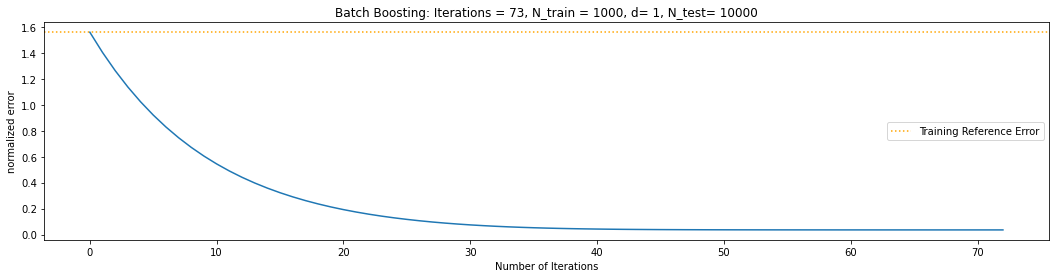

In [82]:
plt.figure(figsize = (18, 4))
plt.axhline(train_error[0], ls=':', color = 'orange', label = 'Training Reference Error')
plt.plot(np.arange(len(train_error)) ,train_error)
plt.title(f"Batch Boosting: Iterations = {len(train_error)}, N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("Number of Iterations")

plt.ylabel("normalized error")
plt.legend(loc='center right')
plt.show()

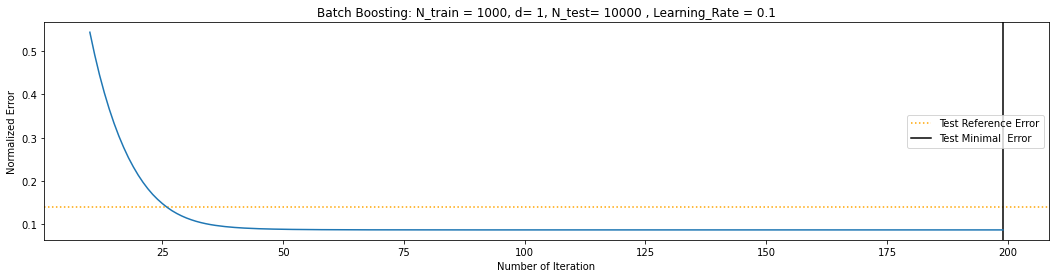

In [76]:
plt.figure(figsize = (18, 4))
plt.axhline(test_reference_error, ls=':', color = 'orange', label = 'Test Reference Error')
plt.axvline(min_error[1], ls='-', color = 'k', label = 'Test Minimal  Error')
plt.plot(np.arange(10,len(test_error[:])) , test_error[10:])
plt.title(f"Batch Boosting: N_train = {N_train}, d= {d}, N_test= {N_test} , Learning_Rate = {Learning_Rate}")
plt.xlabel("Number of Iteration")

plt.ylabel("Normalized Error")
plt.legend(loc='center right')
plt.show()